# DFF

In [9]:
import matplotlib
import torch
import os
import timm
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import numpy as np
import requests
import cv2
import torch
import pytorch_grad_cam
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image, show_factorization_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

In [10]:
def load_model_using_weight_file(file_path):
    # Replace 'vit_base_patch16_224' with your specific architecture
    model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)
    checkpoint = torch.load(file_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

    model.load_state_dict(checkpoint, strict=False)
    model.eval()

    return model

In [11]:
def load_kaggle_data():
    imagenet_image_files = []
    for dirpath, _, filenames in os.walk('../PlumSmile_data/dog_emotions/test'):
        for file in filenames:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                imagenet_image_files.append(os.path.join(dirpath, file))
    return imagenet_image_files

imagenet_image_files = load_kaggle_data()

In [12]:
def get_image_from_path(path):
    """Loads and resizes an image from a local file path and returns:
    - Resized image as NumPy array (RGB, uint8)
    - Normalized RGB float image
    - Preprocessed torch tensor ready for the model
    """
    img = Image.open(path).convert("RGB").resize((224, 224))
    img_np = np.array(img)
    rgb_img_float = np.float32(img_np) / 255.0
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img_np, rgb_img_float, input_tensor

# def create_labels(concept_scores, top_k=2):
#     """
#     Create a list with the dog emotion category names of the top scoring categories.

#     :param concept_scores: numpy array of shape (num_concepts, num_classes)
#     :param top_k: number of top categories to show per concept
#     :return: List of strings, one per concept, with top_k emotion labels and scores
#     """
#     emotion_labels = ["Happy", "Sad", "Relax", "Angry"]
#     concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
#     concept_labels_topk = []

#     for concept_index in range(concept_categories.shape[0]):
#         categories = concept_categories[concept_index]
#         concept_labels = []
#         for category in categories:
#             score = concept_scores[concept_index, category]
#             label = f"{emotion_labels[category]}: {score:.2f}"
#             concept_labels.append(label)
#         concept_labels_topk.append("\n".join(concept_labels))
    
#     return concept_labels_topk

def create_labels(concept_scores: np.ndarray,
                          labels=None,
                          top_k: int = 2):
    """
    Create top-K emotion labels with scores for each example.

    Args:
        concept_scores: array of shape (N, C) where C is the number of emotions.
        emotion_names: list of length C with names of each emotion.
                       Defaults to ['happy','sad','relax','angry'].
        top_k: number of top emotions to return per example.

    Returns:
        List of length N, each element is a newline-joined string of
        "emotion:score" for the top_k emotions.
    """
    if labels is None:
        labels = {
            0: "happy",
            1: "sad",
            2: "relaxed",
            3: "angry"
        }
        
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    print(concept_categories)
    concept_labels_topk = []
    for concept_index in range(concept_categories.shape[0]):
        categories = concept_categories[concept_index, :]    
        concept_labels = []
        for category in categories:
            score = concept_scores[concept_index, category]
            label = f"{labels[category].split(',')[0]}:{score:.2f}"
            concept_labels.append(label)
        concept_labels_topk.append("\n".join(concept_labels))
    return concept_labels_topk

In [13]:
def visualize_image(model, img_path, n_components=4, top_k=2):
    img, rgb_img_float, input_tensor = get_image_from_path(img_path)

    print("Input Tensor Shape:" , input_tensor.shape)

    classifier = model.head
    target_layer = model.blocks[-1].norm2
    reshape_transform = vit_reshape_transform
    
    dff = DeepFeatureFactorization(
        model=model,
        target_layer=target_layer,
        reshape_transform=reshape_transform,
        computation_on_concepts=classifier
    )

    concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components=n_components)
    concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), dim=-1).numpy()

    print("Concept Outputs: ", concept_outputs.shape)

    concept_label_strings = create_labels(concept_outputs, top_k=top_k)

    visualization = show_factorization_on_image(
        rgb_img_float,
        batch_explanations[0],
        image_weight=0.3,
        concept_labels=concept_label_strings
    )

    result = np.hstack((img, visualization))

    print(result.shape)

    # if result.shape[0] > 500:
    #     result = cv2.resize(result, (result.shape[1] // 4, result.shape[0] // 4))
    return result

In [14]:
model = load_model_using_weight_file('./vit_face_combined_annotated_best.pth')

Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[3 1]
 [3 1]
 [1 3]
 [1 3]]
(224, 672, 3)


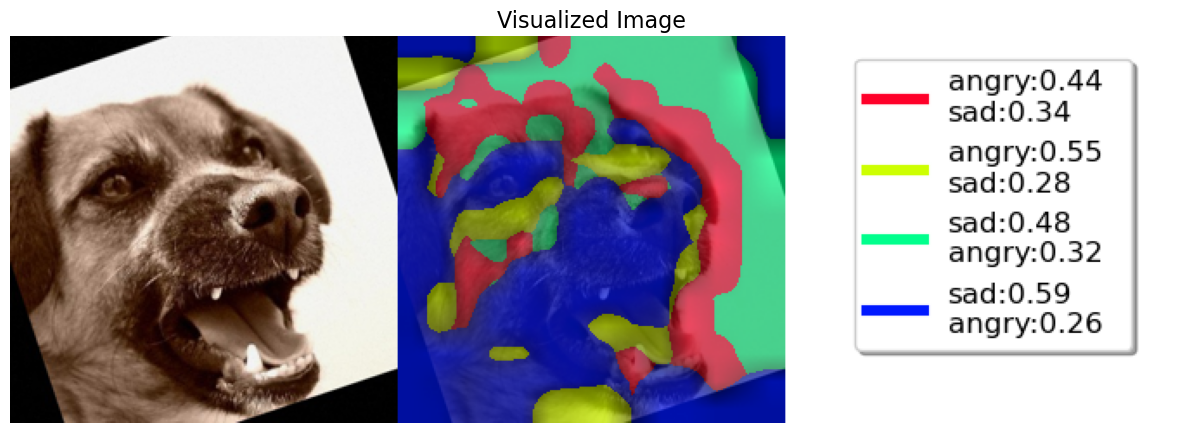

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

output = visualize_image(model, imagenet_image_files[0])

plt.figure(figsize=(15, 15))  # Increase the figure size (width=12, height=8 inches)
plt.imshow(output)
plt.axis('off')
plt.title("Visualized Image", fontsize=16)
plt.show()

Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[3 1]
 [3 2]
 [1 3]
 [1 3]]
(224, 672, 3)


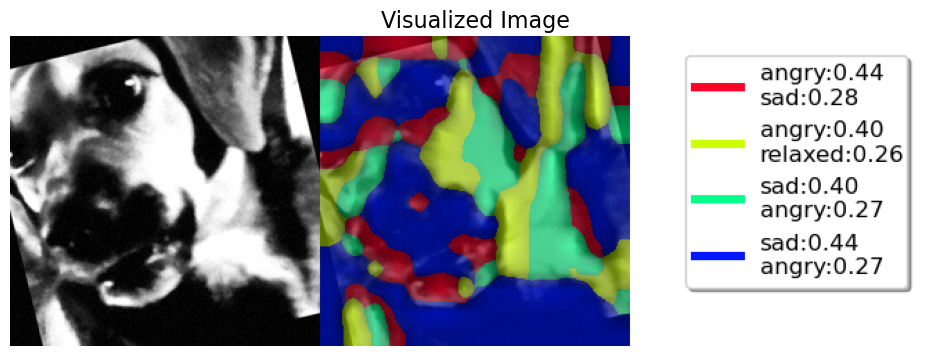

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

output = visualize_image(model, imagenet_image_files[10])

plt.figure(figsize=(12, 8))  # Increase the figure size (width=12, height=8 inches)
plt.imshow(output)
plt.axis('off')
plt.title("Visualized Image", fontsize=16)
plt.show()